In [1]:
import random
import matplotlib.pyplot as plt

In [2]:
class KnapsackProblem:
    def __init__(self, weights, values, capacity):
        self.weights = weights
        self.values = values
        self.capacity = capacity
        self.num_items = len(weights)

class Individual:
    def __init__(self, problem: KnapsackProblem):
        self.problem = problem
        self.genotype = [random.random() < 0.5 for _ in range(problem.num_items)]
        self.fitness = self.evaluate_fitness()

    def evaluate_fitness(self):
        total_weight = 0
        total_value = 0

        for i, bit in enumerate(self.genotype):
            if bit:
                total_weight += self.problem.weights[i]
                total_value += self.problem.values[i]
        
        if total_weight > self.problem.capacity:
            return -1
        
        return total_value

Crossover definitions

In [3]:
# Crossover Operators
def arithmetic_crossover(p1, p2, alpha=None):
    if alpha is None:
        alpha = random.random()
    
    child1 = Individual(p1.problem)
    child2 = Individual(p2.problem)
    
    child1.genotype = [
        bool(round(alpha * g1 + (1 - alpha) * g2))
        for g1, g2 in zip(p1.genotype, p2.genotype)
    ]
    child2.genotype = [
        bool(round(alpha * g2 + (1 - alpha) * g1))
        for g1, g2 in zip(p1.genotype, p2.genotype)
    ]
    
    return child1, child2


def single_point_crossover(p1, p2):
    point = random.randint(1, len(p1.genotype) - 1)

    child1 = Individual(p1.problem)
    child2 = Individual(p2.problem)

    child1.genotype = p1.genotype[:point] + p2.genotype[point:]
    child2.genotype = p2.genotype[:point] + p1.genotype[point:]

    return child1, child2

def two_point_crossover(p1, p2):
    a, b = sorted(random.sample(range(len(p1.genotype)), 2))

    child1 = Individual(p1.problem)
    child2 = Individual(p2.problem)

    child1.genotype = (
        p1.genotype[:a] + p2.genotype[a:b] + p1.genotype[b:]
    )
    child2.genotype = (
        p2.genotype[:a] + p1.genotype[a:b] + p2.genotype[b:]
    )

    return child1, child2

def uniform_crossover(p1, p2):
    child1 = Individual(p1.problem)
    child2 = Individual(p2.problem)

    child1.genotype = []
    child2.genotype = []

    for bit1, bit2 in zip(p1.genotype, p2.genotype):
        if random.random() < 0.5:
            child1.genotype.append(bit1)
            child2.genotype.append(bit2)
        else:
            child1.genotype.append(bit2)
            child2.genotype.append(bit1)

    return child1, child2


Selection definitions

In [4]:
def selection(population, tournament_size):
    candidates = random.sample(population, tournament_size)
    return max(candidates, key=lambda ind: ind.fitness)


Mutation definitions

In [5]:
def bit_flip_mutation(individual, mutation_rate):
    for i in range(len(individual.genotype)):
        if random.random() < mutation_rate:
            individual.genotype[i] = not individual.genotype[i]
    # individual.fitness = individual.evaluate_fitness()


def swap_mutation(individual):
    idx1, idx2 = random.sample(range(len(individual.genotype)), 2)
    individual.genotype[idx1], individual.genotype[idx2] = individual.genotype[idx2], individual.genotype[idx1]
    # individual.fitness = individual.evaluate_fitness()


def scramble_mutation(individual):
    start, end = sorted(random.sample(range(len(individual.genotype)), 2))
    subseq = individual.genotype[start:end]
    random.shuffle(subseq)
    individual.genotype[start:end] = subseq
    # individual.fitness = individual.evaluate_fitness()


In [6]:
def genetic_algorithm(
    problem: KnapsackProblem,
    population_size=50,
    generations=50,
    tournament_size=3,
    mutation_rate=0.05,
    elitism_size=2,
    crossover_op='single_point',        # choose: 'single_point', 'two_point', 'uniform'
    mutation_op='bit_flip'              # choose: 'bit_flip', 'swap', 'scramble'
):
    population = [Individual(problem) for _ in range(population_size)]

    crossover_ops = {
        'single_point': single_point_crossover,
        'two_point': two_point_crossover,
        'uniform': uniform_crossover,
        'arithmetic': arithmetic_crossover
    }

    mutation_ops = {
        'bit_flip': lambda ind: bit_flip_mutation(ind, mutation_rate),
        'swap': swap_mutation,
        'scramble': scramble_mutation
    }

    crossover_func = crossover_ops[crossover_op]
    mutation_func = mutation_ops[mutation_op]

    # track progress
    best_per_gen = []

    for gen in range(generations):
        population.sort(key=lambda ind: ind.fitness, reverse=True)
        best_per_gen.append(population[0].fitness)
      
        new_population = population[:elitism_size]

        while len(new_population) < population_size:
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)
            child1, child2 = crossover_func(parent1, parent2)

            mutation_func(child1)
            mutation_func(child2)

            child1.fitness = child1.evaluate_fitness()
            child2.fitness = child2.evaluate_fitness()

            new_population.extend([child1, child2])

        population = new_population[:population_size]

    # return max(population, key=lambda ind: ind.fitness)
    best_ind = max(population, key=lambda ind: ind.fitness)

    return best_ind, best_per_gen


Best genotype: [False, True, True, True, True]
Best fitness (value): 15


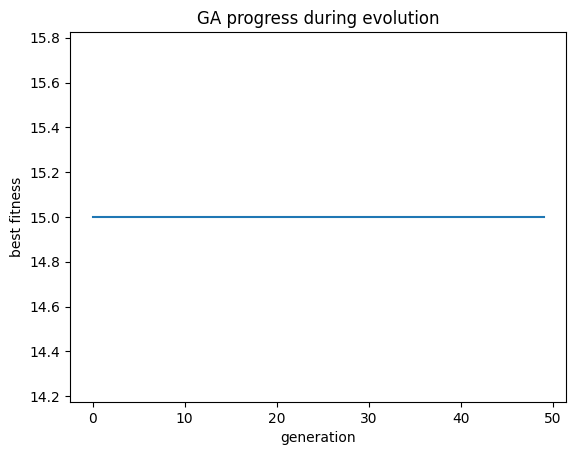

In [7]:
weights = [12, 2, 1, 1, 4]
values =  [4, 2, 2, 1, 10]
capacity = 15

problem = KnapsackProblem(weights, values, capacity)

best, progress = genetic_algorithm(
    problem=problem,
    population_size=150,
    generations=50,
    mutation_rate=0.05,
    crossover_op='arithmetic',
    mutation_op='scramble',
)

print("Best genotype:", best.genotype)
print("Best fitness (value):", best.fitness)

plt.plot(progress)
plt.xlabel("generation")
plt.ylabel("best fitness")
plt.title("GA progress during evolution")
plt.show()

In [8]:
def load_kplib_instance(path):
    with open(path, "r") as f:
        lines = [line.strip() for line in f if line.strip()]  

    n = int(lines[0])           
    capacity = int(lines[1])   
    
    weights = []
    values = []
    
    for line in lines[2:2+n]:
        w, v = map(int, line.split())
        weights.append(w)
        values.append(v)
    
    return weights, values, capacity

Best genotype: [False, False, True, True, True, True, False, True, True, False, False, False, True, False, False, True, False, True, False, True, False, False, False, False, True, False, True, False, True, False, False, False, False, True, False, True, True, False, False, False, False, False, False, True, True, False, False, False, True, True, False, True, True, True, False, False, True, False, False, False, True, False, False, True, True, True, False, True, True, True, True, False, False, True, True, True, False, False, False, False, False, False, True, False, True, False, True, False, False, True, True, False, True, False, True, True, False, True, False, True, False, True, False, True, True, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, True, False, True, True, False, True, False, True, True, True, True, False, True, False, True, False, True, True, True, False, False, True, True, False, False, True, True, False, False, True, Tru

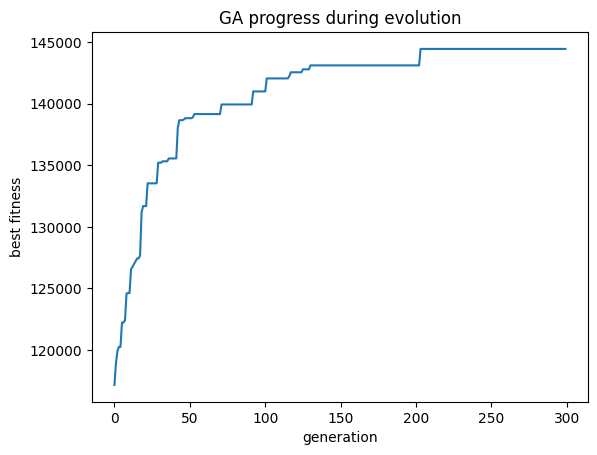

In [9]:
instance_path = "../instances/n00500_R01000_s000.kp" 
weights, values, capacity = load_kplib_instance(instance_path)

problem = KnapsackProblem(weights, values, capacity)

best, progress = genetic_algorithm(
    problem=problem,
    population_size=150,
    generations=300,
    mutation_rate=0.05,
    crossover_op='arithmetic',
    mutation_op='bit_flip',
)

print("Best genotype:", best.genotype)
print("Best fitness (value):", best.fitness)

plt.plot(progress)
plt.xlabel("generation")
plt.ylabel("best fitness")
plt.title("GA progress during evolution")
plt.show()